In [56]:
# Import the Python library and module and configure running information
from easydict import EasyDict as edict
# Dictionary access, used to store hyperparameters
import os
# os module, used to process files and directories
import numpy as np
# Scientific computing library
import matplotlib.pyplot as plt
# Graphing library
import mindspore
# MindSpore library
import mindspore.dataset as ds
# Dataset processing module
from mindspore.dataset import vision as VS
# Image enhancement module
from mindspore import context
#Environment setting module
import mindspore.nn as nn
# Neural network module
from mindspore.train import Model
# Model build
from mindspore.nn.optim.momentum import Momentum
# Momentum optimizer
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
# Model saving settings
from mindspore import Tensor
# Tensor
from mindspore.train.serialization import export
# Model export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
# Loss value smoothing
from mindspore.train.serialization import load_checkpoint, load_param_into_net
# Model loading
import mindspore.ops as ops
# Common operators
# MindSpore execution mode and device setting
mindspore.set_device("CPU")
context.set_context(mode=context.GRAPH_MODE)

In [59]:
# Define parameter variables.
cfg = edict({
 'data_path': 'C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/flower_photos/flower_photos_train/flower_photos_train', # Path of the training dataset
 'test_path':'C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/flower_photos/flower_photos_test/flower_photos_test', # Path of the test dataset
 'data_size': 3616,
 'HEIGHT': 224, # Image height
 'WIDTH': 224, # Image width
 '_R_MEAN': 123.68, # Average value of CIFAR-10
 '_G_MEAN': 116.78,
 '_B_MEAN': 103.94,
 '_R_STD': 1, # Customized standard deviation
 '_G_STD': 1,
 '_B_STD':1,
 '_RESIZE_SIDE_MIN': 256, # Minimum resize value for image enhancement
 '_RESIZE_SIDE_MAX': 512,

 'batch_size': 16, # Batch size
 'num_class': 5, # Number of classes
 'epoch_size': 5, # Number of training times
 'loss_scale_num':1024,

 'prefix': 'resnet-ai', # Name of the model
 'directory': './model_resnet', # Path for storing the model
 'save_checkpoint_steps': 10, # The checkpoint is saved every 10 steps.
})

Number of training datasets:  3616
Number of test datasets:  52
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  1


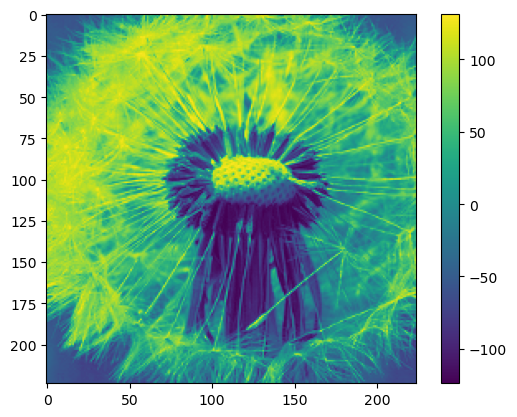

In [60]:
# Read and process data.
# Data processing
def read_data(path,config,usage="train"):
 # Read the source dataset of an image from a directory.
 dataset = ds.ImageFolderDataset(path, class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
 # define map operations
 # Operator for image decoding
 decode_op = VS.Decode()
 # Operator for image normalization
 normalize_op = VS.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD,
cfg._G_STD, cfg._B_STD])
 # Operator for image resizing
 resize_op = VS.Resize(cfg._RESIZE_SIDE_MIN)
 # Operator for image cropping
 center_crop_op = VS.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
 # Operator for image random horizontal flipping
 horizontal_flip_op = VS.RandomHorizontalFlip()
 # Operator for image channel quantity conversion
 channelswap_op = VS.HWC2CHW()
 # Operator for random image cropping, decoding, encoding, and resizing
 random_crop_decode_resize_op = VS.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)
 # Preprocess the training set.
 if usage == 'train':
     dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
     dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
 # Preprocess the test set.
 else:
     dataset = dataset.map(input_columns="image", operations=decode_op)
     dataset = dataset.map(input_columns="image", operations=resize_op)
     dataset = dataset.map(input_columns="image", operations=center_crop_op)

 # Preprocess all datasets.
 dataset = dataset.map(input_columns="image", operations=normalize_op)
 dataset = dataset.map(input_columns="image", operations=channelswap_op)
 # Batch the training set.
 if usage == 'train':
     dataset = dataset.shuffle(buffer_size=10000) # 10000 as in imageNet train script
     dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
 # Batch the test set.
 else:
     dataset = dataset.batch(1, drop_remainder=True)

 # Data augmentation
 dataset = dataset.repeat(1)

 dataset.map_model = 4
 return dataset

# Display the numbers of training sets and test sets.
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('Number of training datasets: ',de_train.get_dataset_size()*cfg.batch_size)# get_dataset_size() obtains the batch processing size.
print('Number of test datasets: ',de_test.get_dataset_size())

# Display the sample graph of the training set.
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0,...].shape)
print('Label style of an image: ', data_next['label'][0]) # Total 5 label classes which are represented by numbers from 0 to 4.
plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [61]:
# Build and train the model.
"""ResNet."""
# Define the weight initialization function.
def _weight_variable(shape, factor=0.01):
 init_value = np.random.randn(*shape).astype(np.float32) * factor
 return Tensor(init_value)

# Define the 3x3 convolution layer functions.
def _conv3x3(in_channel, out_channel, stride=1):
 weight_shape = (out_channel, in_channel, 3, 3)
 weight = _weight_variable(weight_shape)
 return nn.Conv2d(in_channel, out_channel,
 kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# Define the 1x1 convolution layer functions.
def _conv1x1(in_channel, out_channel, stride=1):
 weight_shape = (out_channel, in_channel, 1, 1)
 weight = _weight_variable(weight_shape)
 return nn.Conv2d(in_channel, out_channel,
 kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# Define the 7x7 convolution layer functions.
def _conv7x7(in_channel, out_channel, stride=1):
 weight_shape = (out_channel, in_channel, 7, 7)
 weight = _weight_variable(weight_shape)
 return nn.Conv2d(in_channel, out_channel,
 kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# Define the Batch Norm layer functions.
def _bn(channel):
 return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
 gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

# Define the Batch Norm functions at the last layer.
def _bn_last(channel):
 return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
 gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

# Define the functions of the fully-connected layers.
def _fc(in_channel, out_channel):
 weight_shape = (out_channel, in_channel)
 weight = _weight_variable(weight_shape)
 return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

# Construct a residual module.
class ResidualBlock(nn.Cell):
 """
 ResNet V1 residual block definition.
 Args:
 in_channel (int): Input channel.
 out_channel (int): Output channel.
 stride (int): Stride size for the first convolutional layer. Default: 1.
 Returns:
 Tensor, output tensor.
 Examples:
 >>> ResidualBlock(3, 256, stride=2)
 """
 expansion = 4 # In conv2_x--conv5_x, the number of convolution kernels at the first two layers is one fourth of the number of convolution kernels at the third layer (an output channel).
 def __init__(self, in_channel, out_channel, stride=1):
     super(ResidualBlock, self).__init__()
     # The number of convolution kernels at the first two layers is equal to a quarter of the number of convolution kernels at the output channels.
     channel = out_channel // self.expansion

     # Layer 1 convolution
     self.conv1 = _conv1x1(in_channel, channel, stride=1)
     self.bn1 = _bn(channel)
     # Layer 2 convolution
     self.conv2 = _conv3x3(channel, channel, stride=stride)
     self.bn2 = _bn(channel)

     # Layer 3 convolution. The number of convolution kernels is equal to that of output channels.
     self.conv3 = _conv1x1(channel, out_channel, stride=1)
     self.bn3 = _bn_last(out_channel)

     # ReLU activation layer
     self.relu = nn.ReLU()
     self.down_sample = False

     # When the step is not 1 or the number of output channels is not equal to that of input channels, downsampling is performed to adjust the number of channels.
     if stride != 1 or in_channel != out_channel:
         self.down_sample = True
     self.down_sample_layer = None
     # Adjust the number of channels using the 1x1 convolution.
     if self.down_sample:
         self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), # 1x1 convolution
                                                                         _bn(out_channel)]) # Batch Norm
     # Addition operator
     self.add = ops.Add()

    # Construct a residual block.
 def construct(self, x):
     # Input
     identity = x

     # Layer 1 convolution 1x1
     out = self.conv1(x)
     out = self.bn1(out)
     out = self.relu(out)

     # Layer 2 convolution 3x3
     out = self.conv2(out)
     out = self.bn2(out)
     out = self.relu(out)

     # Layer 3 convolution 1x1
     out = self.conv3(out)
     out = self.bn3(out)

     # Change the network dimension.
     if self.down_sample:
         identity = self.down_sample_layer(identity)

     # Add the residual.
     out = self.add(out, identity)
     # ReLU activation
     out = self.relu(out)

     return out

# Construct a residual network.
class ResNet(nn.Cell):
 """
 ResNet architecture.
 Args:
     block (Cell): Block for network.
     layer_nums (list): Numbers of block in different layers.
     in_channels (list): Input channel in each layer.
     out_channels (list): Output channel in each layer.
     strides (list): Stride size in each layer.
     num_classes (int): The number of classes that the training images belong to.
     Returns:
     Tensor, output tensor.
     Examples:
     >>> ResNet(ResidualBlock,
     >>> [3, 4, 6, 3],
     >>> [64, 256, 512, 1024],
     >>> [256, 512, 1024, 2048],
     >>> [1, 2, 2, 2],
     >>> 10)
    """
 # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, stride, and number of image classes
 def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
     super(ResNet, self).__init__()
     if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
         raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
     # Layer 1 convolution; convolution kernels: 7x7, input channels: 3; output channels: 64; step: 2
     self.conv1 = _conv7x7(3, 64, stride=2)
     self.bn1 = _bn(64)
     self.relu = ops.ReLU()

     # 3x3 pooling layer; step: 2
     self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
     # conv2_x residual block
     self.layer1 = self._make_layer(block, layer_nums[0], in_channel=in_channels[0], out_channel=out_channels[0], stride=strides[0])
     # conv3_x residual block
     self.layer2 = self._make_layer(block, layer_nums[1], in_channel=in_channels[1], out_channel=out_channels[1], stride=strides[1])
     # conv4_x residual block
     self.layer3 = self._make_layer(block, layer_nums[2], in_channel=in_channels[2], out_channel=out_channels[2], stride=strides[2])
     # conv5_x residual block
     self.layer4 = self._make_layer(block, layer_nums[3], in_channel=in_channels[3], out_channel=out_channels[3], stride=strides[3])
     # Mean operator
     self.mean = ops.ReduceMean(keep_dims=True)
     # Flatten layer
     self.flatten = nn.Flatten()
     # Output layer
     self.end_point = _fc(out_channels[3], num_classes)
 # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, and stride
 def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
     """
     Make stage network of ResNet.
     Args:
     block (Cell): Resnet block.
     layer_num (int): Layer number.
     in_channel (int): Input channel.
     out_channel (int): Output channel.
     stride (int): Stride size for the first convolutional layer.
     Returns:
     SequentialCell, the output layer.
     Examples:
     >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
     """
     # Build the residual block of convn_x.

     layers = []

     resnet_block = block(in_channel, out_channel, stride=stride)
     layers.append(resnet_block)
     for _ in range(1, layer_num):
         resnet_block = block(out_channel, out_channel, stride=1)
         layers.append(resnet_block)
     return nn.SequentialCell(layers)

 # Build a ResNet network.
 def construct(self, x):
     x = self.conv1(x) # Layer 1 convolution: 7x7; step: 2
     x = self.bn1(x) # Batch Norm of layer 1
     x = self.relu(x) # ReLU activation layer
     c1 = self.maxpool(x) # Max pooling: 3x3; step: 2
     c2 = self.layer1(c1) # conv2_x residual block
     c3 = self.layer2(c2) # conv3_x residual block
     c4 = self.layer3(c3) # conv4_x residual block
     c5 = self.layer4(c4) # conv5_x residual block
     out = self.mean(c5, (2, 3)) # Mean pooling layer
     out = self.flatten(out) # Flatten layer
     out = self.end_point(out) # Output layer
     return out

# Build a ResNet-50 network.
def resnet50(class_num=5):
 """
 Get ResNet50 neural network.
 Args:
 class_num (int): Class number.
 Returns:
 Cell, cell instance of ResNet50 neural network.
 Examples:
 >>> net = resnet50(10)
 """
 return ResNet(ResidualBlock, # Residual block
                 [3, 4, 6, 3], # Number of residual blocks
                 [64, 256, 512, 1024], # Input channel
                 [256, 512, 1024, 2048], # Output channel
                 [1, 2, 2, 2], # Step
                 class_num) # Number of output classes


In [62]:
# Modify pre-trained model parameters
# Construct a ResNet-50 network. The number of output classes is 5, corresponding to five flower classes.
net=resnet50(class_num=cfg.num_class)

# Read the parameters of the pre-trained model.
param_dict = load_checkpoint("model_resnet/resnet50_ascend_v170_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt")

# Display the read model parameters.
print(param_dict)

# Modify the shape corresponding to end_point.weight and end_point.bias by using mindspore.Parameter().
param_dict["end_point.weight"] = mindspore.Parameter(Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable")
param_dict["end_point.bias"]= mindspore.Parameter(Tensor(param_dict["end_point.bias"][:5,], mindspore.float32), name="variable")

# Set the Softmax cross-entropy loss function.
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# Set the learning rate.
train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * cfg.epoch_size,step_per_epoch=train_step_size, decay_epoch=cfg.epoch_size)

# Set the momentum optimizer.
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

# Smooth the loss value to solve the problem of the gradient being too small during training.
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# Build the model. Input the network structure, loss function, optimizer, loss value smoothing, and model evaluation metrics.
model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

# Loss value monitoring
loss_cb = LossMonitor(per_print_times=train_step_size)

# Model saving parameters. Set the number of steps for saving a model and the maximum number of models that can be saved.
ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)

# Save the model. Set the name, path, and parameters for saving the model.
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)
print("============== Starting Training ==============")

# Train the model. Set the training times, training set, callback function, and whether to use the data offloading mode (can be applied on Ascend and GPUs to accelerate training speed).
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)

# The training takes 15 to 20 minutes.
# Use the test set to validate the model and output the accuracy of the test set.
metric = model.eval(de_test)
print(metric)

{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co

============== Starting Training ==============
epoch: 1 step: 226, loss is 1.014898657798767
epoch: 2 step: 226, loss is 1.2451106309890747
epoch: 3 step: 226, loss is 1.2455177307128906
epoch: 4 step: 226, loss is 1.0164825916290283
epoch: 5 step: 226, loss is 0.9592575430870056
{'acc': 0.7115384615384616}


In [65]:
# Use the model for prediction
# Model prediction. Select 10 samples from the test set for testing and output the prediction result and actual result.
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
for i in range(10):
 test_ = de_test.create_dict_iterator().__next__()
 test = Tensor(test_['image'], mindspore.float32)
 # Use the model for prediction.
 predictions = model.predict(test)
 predictions = predictions.asnumpy()
 true_label = test_['label'].asnumpy()
 # Show the prediction result.
 p_np = predictions[0, :]
 pre_label = np.argmax(p_np)
print('Prediction result of the ' + str(i) + '-th sample: ', class_names[pre_label], ' Actual result: ',
class_names[true_label[0]])

Prediction result of the 9-th sample:  dandelion  Actual result:  dandelion
